# Autism classification

This example uses data from 20 participants of the [Autism Brain Imaging Data Exchange (ABIDE)](http://preprocessed-connectomes-project.org/abide/) preprocessed connectomes dataset. The goal is to predict an autism diagnosis from static functional connectivity estimates. Please note that the results may overestimate the true effect because of statistical issues when performing prediction with tens of thousands of features and relatively few observations.

The multiverse is is similar to the classification multiverse perfomed by [Dafflon et al. 2022](https://www.nature.com/articles/s41467-022-31347-8) with the main difference being that we here implement a slightly reduced decision space for the connectivity and pracellation measures, but include an additional decision point for the regularisation strength of the classifier to also cover the statistical model. 

## Data Download

The data is accessed through [nilearn](https://nilearn.github.io/dev/modules/generated/nilearn.datasets.fetch_abide_pcp.html). Please note that downloading the full data will take a while and requires ~20 GB of memory. If the download crashes or the code cell was aborted, you can simply re-run the code cell and it will continue with only the missing data.

Note: For quicker testing purposes, a subset of 20 subjects was provided by adding `SUB_ID=SUB_IDS` to the `datasets.fetch_abide_pcp()` arguments in the data download as well as in the multiverse analysis code cell. If you wish to run the analysis for the whole dataset to reproduce the included figures, please remove this argument from both functions.

In [1]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from itertools import product
from pathlib import Path
from tqdm import tqdm
from nilearn import datasets

pipelines = ["cpac", "ccs", "dparsf", "niak"]
band_pass = [True, False]
global_signal = [True, False]
parcellations = ["rois_aal", "rois_cc200", "rois_dosenbach160"]

PARALLEL_THREADS = 48
DATA_DIR = Path("./abide_data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Subset of subjects to download
SUB_IDS = [50012, 50014, 50015, 50016, 50020, 50022, 50023, 50024, 50025, 50027, # controls
           50030, 50031, 50032, 50033, 50034, 50035, 50036, 50037, 50038, 50040] # autism

def fetch_data(pipe, bp, gsr, parc):
    bunch = datasets.fetch_abide_pcp(SUB_ID=SUB_IDS, data_dir="./abide_data", verbose=0, 
                                     pipeline=pipe, derivatives=parc, band_pass_filtering=bp, global_signal_regression=gsr)
    return (pipe, bp, gsr, parc), bunch

all_combinations = list(product(pipelines, band_pass, global_signal, parcellations))
abide_dataset = {}

with ThreadPoolExecutor(max_workers=PARALLEL_THREADS) as ex:
    futures = [ex.submit(fetch_data, *c) for c in all_combinations]
    for fut in tqdm(as_completed(futures), total=len(futures), desc="Fetching ABIDE (parallel)"):
        key, bunch = fut.result()
        abide_dataset[key] = bunch

print(f"Available pipelines: {list(abide_dataset.keys())}")
print(f"Number of subjects:  {len(abide_dataset[('cpac', True, True, 'rois_aal')].phenotypic)}")
print(f"Class distribution:  {abide_dataset[('cpac', True, True, 'rois_aal')].phenotypic['DX_GROUP'].value_counts()}")

Fetching ABIDE (parallel): 100%|██████████| 48/48 [00:06<00:00,  7.99it/s]

Available pipelines: [('cpac', True, True, 'rois_aal'), ('cpac', True, False, 'rois_aal'), ('ccs', True, False, 'rois_dosenbach160'), ('cpac', False, False, 'rois_aal'), ('cpac', False, True, 'rois_aal'), ('ccs', False, True, 'rois_dosenbach160'), ('cpac', True, True, 'rois_dosenbach160'), ('cpac', True, False, 'rois_cc200'), ('ccs', False, False, 'rois_cc200'), ('cpac', True, False, 'rois_dosenbach160'), ('cpac', False, True, 'rois_dosenbach160'), ('ccs', False, True, 'rois_aal'), ('cpac', True, True, 'rois_cc200'), ('ccs', True, True, 'rois_aal'), ('ccs', False, False, 'rois_aal'), ('cpac', False, True, 'rois_cc200'), ('niak', False, False, 'rois_dosenbach160'), ('cpac', False, False, 'rois_dosenbach160'), ('niak', True, True, 'rois_aal'), ('dparsf', True, False, 'rois_aal'), ('niak', True, True, 'rois_dosenbach160'), ('ccs', True, True, 'rois_cc200'), ('ccs', True, False, 'rois_aal'), ('niak', False, False, 'rois_aal'), ('dparsf', False, True, 'rois_aal'), ('niak', False, False, 'ro

## Multiverse Analysis

Available decision points for the preprocessed fMRI time series data are the following:

- Preprocessing pipeline (`'cpac'`, `'ccs'`, `'dparsf'`, `'niak'`)
- Parcellation atlas (`'rois_aal'`, `'rois_cc200'`, `'rois_dosenbach160'`)
- Band pass filtering (`True` or `False`)
- Global signal regression (`True` or `False`) -> If false, standard motion regression was performed

For the connectivity measure, the two methods from the comet toolbox are included:

- Pearson correlation (`comet.connectivity.Static_Pearson`)
- Partial correlation (`comet.connectivity.Static_Partial`)

And for the statistical model we include the regularisation strength (C=0.25, C=1.0)

In [2]:
from comet import multiverse

forking_paths = {
    "pipeline": ["cpac", "ccs", "dparsf", "niak"],                          # Preprocessing pipelines
    "parcellation": ["rois_aal", "rois_cc200", "rois_dosenbach160"],        # Parcellated time series data
    "band_pass": [True, False],                                             # Band-pass filtering   
    "global_signal": [True, False],                                         # Global signal regression     
    "connectivity":[                                                        # Functional connectivity method
        {"name": "pearson", "func": "comet.connectivity.Static_Pearson(ts).estimate()"},
        {"name": "partial", "func": "comet.connectivity.Static_Partial(ts).estimate()"}],
    "regularisation": [0.25, 1.0]                                           # Regularisation strength for the classifier
}

def analysis_template():
    import comet
    import numpy as np
    from nilearn import datasets
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import StratifiedKFold, cross_val_score

    # Subset of subjects do use
    SUB_IDS = [50012, 50014, 50015, 50016, 50020, 50022, 50023, 50024, 50025, 50027, # controls
               50030, 50031, 50032, 50033, 50034, 50035, 50036, 50037, 50038, 50040] # autism

    # Get data (if available, it will be loaded from disk)
    data = datasets.fetch_abide_pcp(SUB_ID=SUB_IDS, data_dir="./abide_data", verbose=0, 
                                    pipeline={{pipeline}},
                                    derivatives={{parcellation}},
                                    band_pass_filtering={{band_pass}},
                                    global_signal_regression={{global_signal}})

    time_series = data[{{parcellation}}]
    diagnosis = data["phenotypic"]["DX_GROUP"]

    # Calculate FC
    tri_ix = None
    features = []

    for ts in time_series:
        FC = {{connectivity}}

        if tri_ix == None:
            tri_ix = np.triu_indices_from(FC, k=1)
        
        feat_vec = FC[tri_ix]
        features.append(feat_vec)

    # Prepare features (FC estimates) and target (autism/control)
    X = np.vstack(features)
    X[np.isnan(X)] = 0.0
    y = np.array(diagnosis)

    # Classification model
    model = Pipeline([('scaler', StandardScaler()), ('reg', LogisticRegression(penalty='l2', C={{regularisation}}, tol=1e-3))])
    cv = StratifiedKFold(n_splits=5)
    accuracies = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

    # Save the results
    comet.utils.save_universe_results({"accuracy": accuracies})

# Create and run the multiverse analysis
mverse = multiverse.Multiverse(name="example_mv_abide")
mverse.create(analysis_template, forking_paths)
mverse.run(parallel=8)

/home/mibur/miniconda3/envs/comet/lib/python3.13/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Starting multiverse analysis for all universes...


Performing multiverse analysis::   0%|          | 0/192 [00:00<?, ?it/s]

The multiverse analysis completed without any errors.


,Universe,Decision 1,Value 1,Decision 2,Value 2,Decision 3,Value 3,Decision 4,Value 4,Decision 5,Value 5,Decision 6,Value 6
0,Universe_1,pipeline,cpac,parcellation,rois_aal,band_pass,True,global_signal,True,connectivity,pearson,regularisation,0.25
1,Universe_2,pipeline,cpac,parcellation,rois_aal,band_pass,True,global_signal,True,connectivity,pearson,regularisation,1.00
2,Universe_3,pipeline,cpac,parcellation,rois_aal,band_pass,True,global_signal,True,connectivity,partial,regularisation,0.25
3,Universe_4,pipeline,cpac,parcellation,rois_aal,band_pass,True,global_signal,True,connectivity,partial,regularisation,1.00
4,Universe_5,pipeline,cpac,parcellation,rois_aal,band_pass,True,global_signal,False,connectivity,pearson,regularisation,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,Universe_188,pipeline,niak,parcellation,rois_dosenbach160,band_pass,False,global_signal,True,connectivity,partial,regularisation,1.00
188,Universe_189,pipeline,niak,parcellation,rois_dosenbach160,band_pass,False,global_signal,False,connectivity,pearson,regularisation,0.25
189,Universe_190,pipeline,niak,parcellation,rois_dosenbach160,band_pass,False,global_signal,False,connectivity,pearson,regularisation,1.00
190,Universe_191,pipeline,niak,parcellation,rois_dosenbach160,band_pass,False,global_signal,False,connectivity,partial,regularisation,0.25


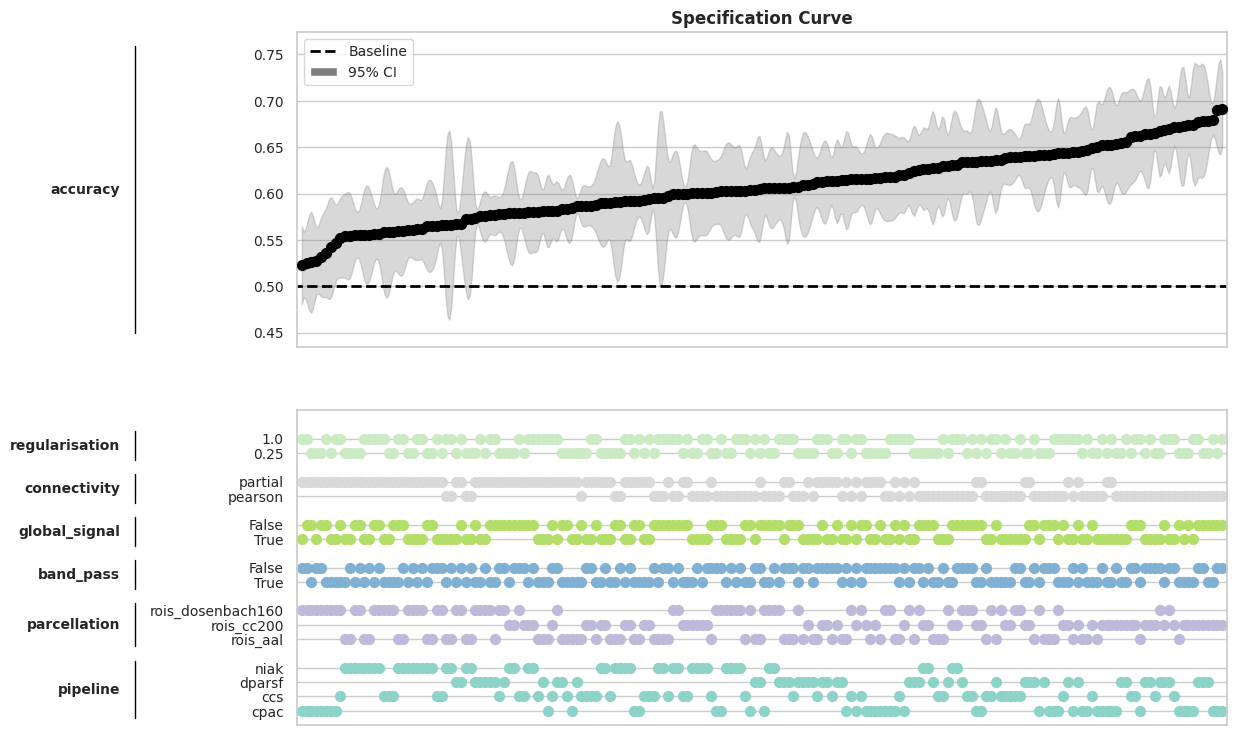

In [3]:
mverse.summary()
mverse.specification_curve("accuracy", height_ratio=(1,1), figsize=(12,9), baseline=0.5, ci=95, line_pad=0.1)